In [1709]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json

In [1710]:
sns.set_theme()
sns.set_style("ticks")
sns.set_context("paper")
sns.set_theme(style="white") #, font_scale=0.5)
# plt.style.use(['seaborn-paper', 'seaborn-ticks'])
sns.set_color_codes()

In [1711]:
import imageio
import rasterio
from rasterio import features
from rasterio import plot
from rasterio import windows
from rasterio import transform

In [1712]:
import geopandas

In [1713]:
data_pth = '/data/neof/{filename}'

In [1714]:
src_mask = rasterio.open(data_pth.format(filename='avgSpatialCoh.tiff'))

filename=['temporalCoherence','avgSpatialCoh','diff_coherence','pre_coherence','co_coherence'][3]
src = rasterio.open(data_pth.format(filename=f'{filename}.tiff'))

Ingest ground truth from 2022 and 2023

In [1715]:
gdf_22 = geopandas.read_file(data_pth.format(filename='coalhaul_visuals_2022.csv'), )
gdf_22[gdf_22==''] = None
gdf_22['geometry'] = geopandas.GeoSeries.from_wkt(gdf_22.geom)
gdf_22.assessment_date = pd.to_datetime(gdf_22.assessment_date)
gdf_22.drop_duplicates(['road_nr', 'link_nr', 'from_km'], inplace=True, ignore_index=True)
gdf_22.set_index(['road_nr', 'link_nr', 'from_km',], inplace=True)

gdf_23 = geopandas.read_file(data_pth.format(filename='coalhaul_visuals_2023.csv'), )
gdf_23[gdf_23==''] = None
gdf_23['geometry'] = geopandas.GeoSeries.from_wkt(gdf_23.geom)
gdf_23.assessment_date = pd.to_datetime(gdf_23.assessment_date)
gdf_23.drop_duplicates(['road_nr', 'link_nr', 'from_km'], inplace=True, ignore_index=True)
gdf_23.set_index(['road_nr', 'link_nr', 'from_km'], inplace=True)

In [1716]:
gdf_22.shape, gdf_23.shape

((918, 98), (919, 98))

In [1717]:
gdf_22.assessment_date.min(), gdf_22.assessment_date.max()

(Timestamp('2022-03-08 00:00:00'), Timestamp('2022-04-07 00:00:00'))

In [1718]:
gdf_23.assessment_date.min(), gdf_23.assessment_date.max()

(Timestamp('2023-03-03 00:00:00'), Timestamp('2023-04-30 00:00:00'))

Select relevant subset of fields from ground truth

In [1719]:
cols = ['geometry', 
 'risfsa_class', 'moisture_zone', 'terrain', 'functional_class', 'road_type', 'road_type_coto', 
 'road_width_m', 
 'width_m', 'lanes', 
 'surface_failures_d', 'surface_failures_e', 
 'surface_cracks_d', 'surface_cracks_e', 
 'stone_loss_d', 'stone_loss_e', 
 'dry_brittle_d', 'dry_brittle_e', 
 'bleeding_d', 'bleeding_e', 
 'block_cracks_d', 'block_cracks_e', 'longitudinal_cracks_d', 'longitudinal_cracks_e', 'transverse_cracks_d', 'transverse_cracks_e', 'crocodile_creacks_d', 'crocodile_cracks_e', 
 'pumping_d', 'pumping_e', 
 'rutting_d', 'rutting_e', 
 'undulation_settlement_d', 'undulation_settlement_e', 
 'patching_d', 'patching_e', 
 'failures_potholes_d', 'failures_potholes_e', 
 'edge_breaks_d', 'edge_breaks_e', 
 'riding_quality',  
 'vci']
# 'assessment_date''route''stone_loss_an','shoulders_unpaved','surface_drainage',

gdf_22 = gdf_22[cols]
gdf_23 = gdf_23[cols]

Remove empty rows and cols

In [1720]:
gdf_22.dropna(axis='columns', how='all', inplace=True)
gdf_23.dropna(axis='columns', how='all', inplace=True)

gdf_22.dropna(axis='index', how='any', inplace=True)
gdf_23.dropna(axis='index', how='any', inplace=True)


gdf_22.shape, gdf_23.shape

((891, 42), (898, 42))

Subset rows from 2022 and 2023 that occure in both years

In [1721]:
index = gdf_23.index.intersection(gdf_22.index)
geometry = gdf_23.loc[index].geometry

Subset the numeric columns only

In [1722]:
numeric_cols = [
       'surface_failures_d', 'surface_failures_e',
       'failures_potholes_d', 'failures_potholes_e', 
       # 'surface_cracks_d', 'surface_cracks_e', 
       'stone_loss_d', 'stone_loss_e',
       'dry_brittle_d', 'dry_brittle_e', 
       'bleeding_d', 'bleeding_e',
       'block_cracks_d', 'block_cracks_e', 'longitudinal_cracks_d', 'longitudinal_cracks_e', 
       'transverse_cracks_d', 'transverse_cracks_e', 'crocodile_creacks_d', 'crocodile_cracks_e', 
       'pumping_d', 'pumping_e', 'rutting_d', 'rutting_e', 
       'undulation_settlement_d', 'undulation_settlement_e', 
       'edge_breaks_d', 'edge_breaks_e', 
       'patching_d', 'patching_e', 
       'road_width_m','width_m', 'lanes', 'riding_quality', 'vci']

In [1723]:
gdf_22 = gdf_22[numeric_cols].astype(float)
gdf_23 = gdf_23[numeric_cols].astype(float)

Select the correct target data

In [1724]:
gdf_change = gdf_23.loc[index, numeric_cols] - gdf_22.loc[index, numeric_cols]
if filename=='pre_coherence':
    gdf = gdf_22.loc[index, numeric_cols]
if filename=='diff_coherence' or filename=='temporalCoherence':
    gdf = gdf_change
else:
    gdf = gdf_23.loc[index, numeric_cols]

In [1725]:
gdf = gdf.set_geometry(geometry)
gdf_change = gdf_change.set_geometry(geometry)

In [1726]:
gdf = gdf.reset_index(drop=True)
gdf_change = gdf_change.reset_index(drop=True)

In [1727]:
res = features.rasterize( ((row.geometry, idx) for idx, row in gdf.iterrows()), fill=-1, transform=src.transform, out_shape=src.shape, all_touched=False)
mask = (res>=0) & (src_mask.read(1)>0)

In [1728]:
rstsource = src.files[0].split("/")[-1].split(".")[0]
rstpath = data_pth.format(filename=f'{rstsource}')

In [1729]:
!mkdir {rstpath}

20516.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
mkdir: cannot create directory ‘/data/neof/pre_coherence’: File exists


In [1730]:
i = 0
seq = []
idxs = []
for idx, row in gdf.iterrows():
    bound = row.geometry.bounds
    rst = src.read(1, window=windows.from_bounds(*bound, src.transform))
    rst_valid = src_mask.read(1, window=windows.from_bounds(*bound, src.transform))
    if rst.shape[0]*rst.shape[1] > 0 and (rst_valid>0).all():
        # print(rst.shape, bound.values)
        i = i + 1        
        tmp_bound = bound
        tmp_rst = rst
        tmp_row = row
        tmp_idx = idx

        imageio.imwrite(data_pth.format(filename=f'{rstsource}/{idx}.tiff'), rst)        
        
        tmp_tran = transform.from_bounds(*bound,rst.shape[1],rst.shape[0])
        
        tmp_msk = features.rasterize( ((row.geometry, 1),), fill=0, transform=tmp_tran, out_shape=rst.shape, all_touched=True)
        imageio.imwrite(data_pth.format(filename=f'{rstsource}/{idx}_mask.tiff'), tmp_msk)

        tmp_seq = [rst[i[0],i[1]] for i in np.argwhere(tmp_msk)]
        seq.append((idx,tmp_seq))
        idxs.append(idx)

        # print(tmp_idx, (tmp_rst*tmp_msk).sum()/tmp_msk.sum())
        # print(tmp_idx, np.mean(tmp_seq))

print(i)

383


In [1731]:
gdf.loc[idxs].to_csv(data_pth.format(filename=f'{rstsource}/targets.csv'))
# gdf_change.loc[idxs].to_csv(data_pth.format(filename=f'{rstsource}/targets_change.csv'))

In [1732]:
with open(data_pth.format(filename=f'{rstsource}/sequences.json'), 'w') as f:
    json.dump(eval(str(seq)), f, ensure_ascii=False)

In [1733]:
df_vals_2 = pd.DataFrame( np.c_[gdf.loc[res[mask],numeric_cols].values], index=res[mask], columns=numeric_cols).groupby(by=res[mask]).first()
# df_vals_2

In [1734]:
zero_count = {}
for col in numeric_cols[:]:
    tmp_res = df_vals_2.loc[:,col].value_counts().sort_index()
    try:
        zero_count[col] = tmp_res.loc[0.0]
    except:
        zero_count[col] = 0
    # print(tmp_res)


In [1735]:
df_vals_2[df_vals_2==0] = np.nan

In [1736]:
df_vals_mean = pd.DataFrame( np.c_[src.read()[0][mask,None]], index=res[mask], columns=['coherence mean']).groupby(by=res[mask]).mean()
df_vals_max  = pd.DataFrame( np.c_[src.read()[0][mask,None]], index=res[mask], columns=['coherence max' ]).groupby(by=res[mask]).max()
df_vals_sum  = pd.DataFrame( np.c_[src.read()[0][mask,None]], index=res[mask], columns=['coherence sum' ]).groupby(by=res[mask]).sum()

In [1737]:
# df_vals = df_vals_mean.join(df_vals_max).join(df_vals_sum).join(df_vals_2)
df_vals = df_vals_mean.join(df_vals_2)

In [1738]:
from scipy.stats import pearsonr
def pearsonr_val(x,y):
        return pearsonr(x,y)[0]

def pearsonr_pval(x,y):
        return pearsonr(x,y)[1]

result = pd.concat([df_vals.corr(method=pearsonr_val).iloc[:,0], df_vals.corr(method=pearsonr_pval).iloc[:,0].rename('p-value mean'), len(df_vals)-pd.Series(zero_count, name="samplesize")], axis=1)
result[result['p-value mean']<=0.05].abs().sum()

/home/tvanzyl/miniforge3/envs/neof_roads/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


coherence mean       1.634392
p-value mean         0.195387
samplesize        2988.000000
dtype: float64

In [1739]:
result.round(3)

,coherence mean,p-value mean,samplesize
coherence mean,1.000,1.000,NaN
surface_failures_d,0.080,0.209,250.0
surface_failures_e,0.007,0.911,250.0
failures_potholes_d,-0.140,0.024,260.0
failures_potholes_e,-0.217,0.000,260.0
stone_loss_d,0.043,0.625,134.0
stone_loss_e,0.049,0.572,134.0
dry_brittle_d,-0.062,0.216,396.0
dry_brittle_e,NaN,NaN,396.0
bleeding_d,-0.062,0.396,187.0


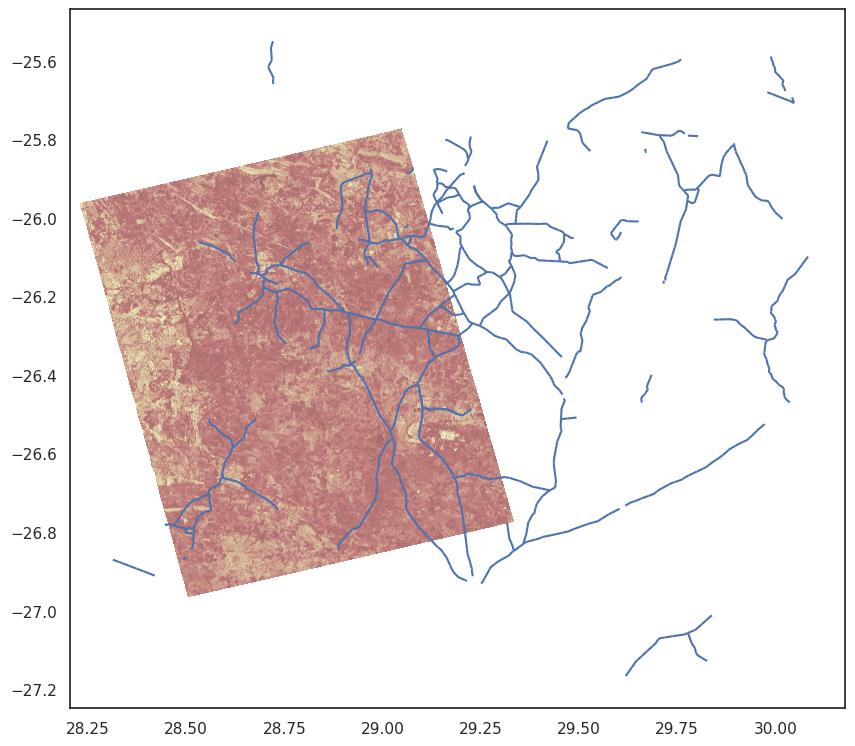

In [1740]:
raster_crs = src.crs

fig, ax = plt.subplots(figsize=(10,10))

# transform rasterio plot to real world coords
extent = [src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
ax = plot.show(src, extent=extent, ax=ax, cmap="pink")

gdf.plot(ax=ax);